# Make individual connectomes and relate them to DDM model parameters (across-subjects)

In [1]:
import nilearn
import matplotlib.pyplot as plt

Use MSDL atlas (based on resting state, Neurospin, Varoquax, 2010)

In [2]:
from nilearn import datasets
atlas = datasets.fetch_atlas_msdl()
# Loading atlas image stored in 'maps'
atlas_filename = atlas['maps']
# Loading atlas data stored in 'labels'
labels = atlas['labels']

## Connectome for single subject

Let's first try to extract a connectome for subject 1, run 1

In [3]:
import pandas

In [4]:
subj_idx = '01'
run = '02'

In [5]:
import os

In [6]:
import nibabel as nb
atlas_im = nb.load(atlas_filename)

In [7]:
path = os.path.join(os.environ['HOME'], 'data/openfmri/ds102/derivatives/fmriprep/sub-{subj_idx}/func/sub-{subj_idx}_task-flankertask'.format(**locals()))

data = path + '_run-{}_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'.format(run)

confounds = path + '_run-{}_bold_confounds.tsv'.format(run)

confounds = pandas.read_csv(confounds, sep='\t', na_values='n/a').fillna(method='bfill')

from nilearn.input_data import NiftiMapsMasker
masker = NiftiMapsMasker(maps_img=atlas_im, standardize=True, memory='nilearn_cache')

time_series = masker.fit_transform(data, confounds=confounds.values)

/Users/gilles/anaconda3/envs/py27/lib/python2.7/site-packages/nilearn/_utils/cache_mixin.py:291: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


time_series contains a 2D array per run of dimension NxM (N=number of volumes, M is number of regions)

In [8]:
%matplotlib inline

In [9]:
time_series.shape

(146, 39)

(0, 100)

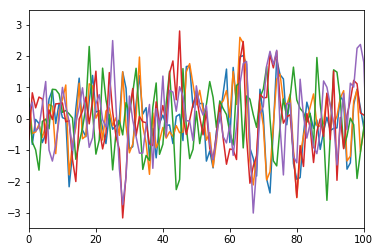

In [10]:
_ = plt.plot(time_series[:, :5], label=labels)
plt.xlim(0, 100)
# plt.legend()

This function plots correlation matrices

In [11]:
def plot_correlation_matrix(correlation_matrix):
    # Display the correlation matrix
    import numpy as np
    from matplotlib import pyplot as plt
    plt.figure(figsize=(10, 10))
    # Mask out the major diagonal
    np.fill_diagonal(correlation_matrix, 0)
    plt.imshow(correlation_matrix, interpolation="nearest", cmap="RdBu_r",
               vmax=0.9, vmin=-0.9)
    plt.colorbar()
    # And display the labels
    x_ticks = plt.xticks(range(len(labels)), labels, rotation=90)
    y_ticks = plt.yticks(range(len(labels)), labels)

We want to plot inline, in the notebook

In [12]:
%matplotlib inline

In [13]:
# This code makes a connectivity matrix using a set of timeseries
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

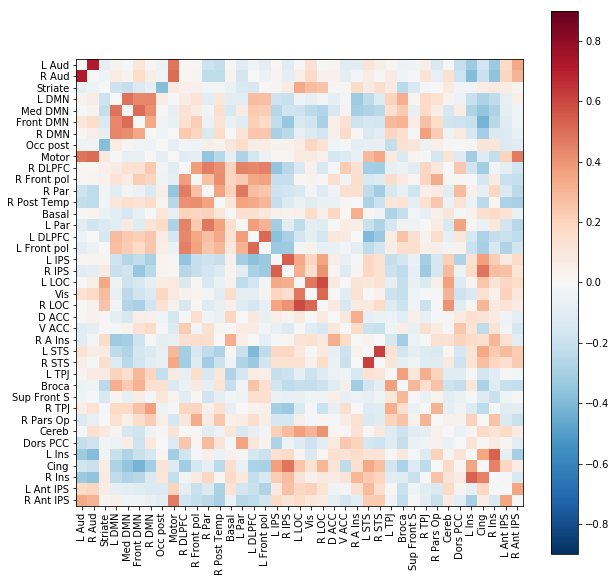

In [14]:
# Here we plot it
plot_correlation_matrix(correlation_matrix)

Nilearn also comes with some very nifty functions that can plot connection strengths on a glass brain

In [15]:
from nilearn import plotting
import numpy as np

For that we need the center-of-mass of every region

In [16]:
coords_connectome = [plotting.find_xyz_cut_coords(img) for img in nilearn.image.iter_img(atlas_im)]

And now we can plot

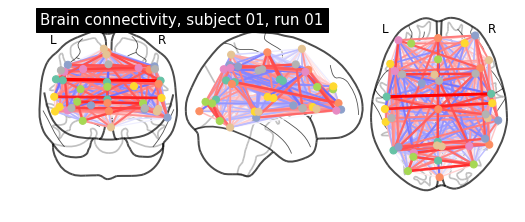

In [17]:
plotting.plot_connectome(correlation_matrix, coords_connectome, title='Brain connectivity, subject 01, run 01')

This gets very cluttered, let's use a [masked array](https://docs.scipy.org/doc/numpy/reference/maskedarray.html) to mask out any connections with a mean r < 0.4

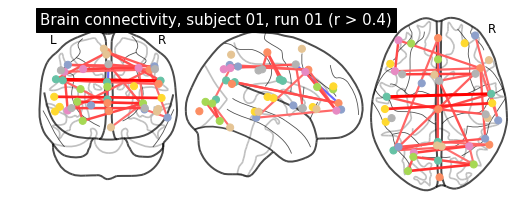

In [18]:
correlation_matrix = np.ma.masked_array(correlation_matrix, np.abs(correlation_matrix) < 0.4)
plotting.plot_connectome(correlation_matrix, coords_connectome, title='Brain connectivity, subject 01, run 01 (r > 0.4)')

## Connectome for all subjects

In [19]:
import matplotlib.pyplot as plt

Now rewrite this into a loop, so we have connectomes for every subject

Working on subject 01
Working on subject 02


/Users/gilles/anaconda3/envs/py27/lib/python2.7/site-packages/nilearn/input_data/base_masker.py:98: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_maps_masker_extractor'
  memory_level=memory_level)(imgs)


Working on subject 03
Working on subject 04
Working on subject 05
Working on subject 06
Working on subject 07
Working on subject 08
Working on subject 09
Working on subject 10
Working on subject 11
Working on subject 12
Working on subject 13
Working on subject 14
Working on subject 15
Working on subject 16
Working on subject 17
Working on subject 18
Working on subject 19
Working on subject 20
Working on subject 21


/Users/gilles/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Working on subject 22
Working on subject 23
Working on subject 24
Working on subject 25
Working on subject 26


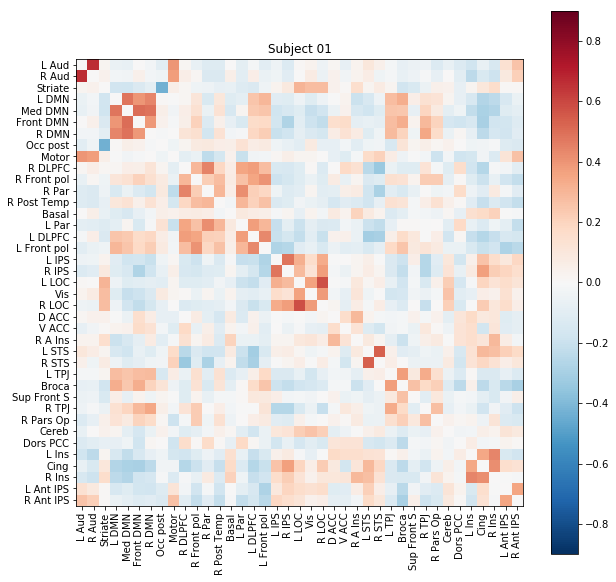

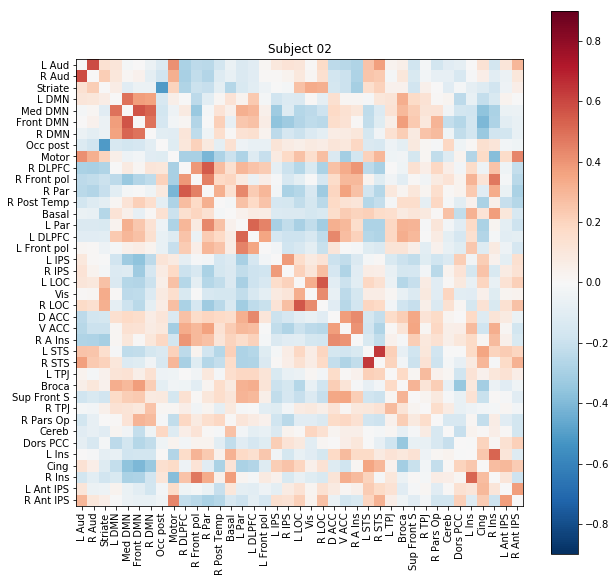

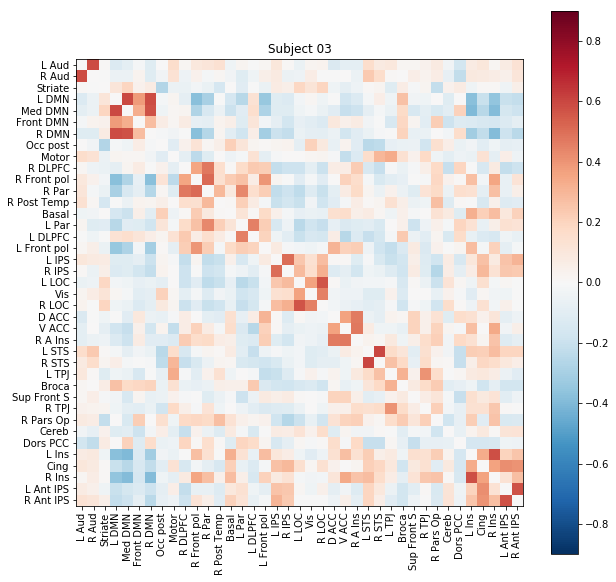

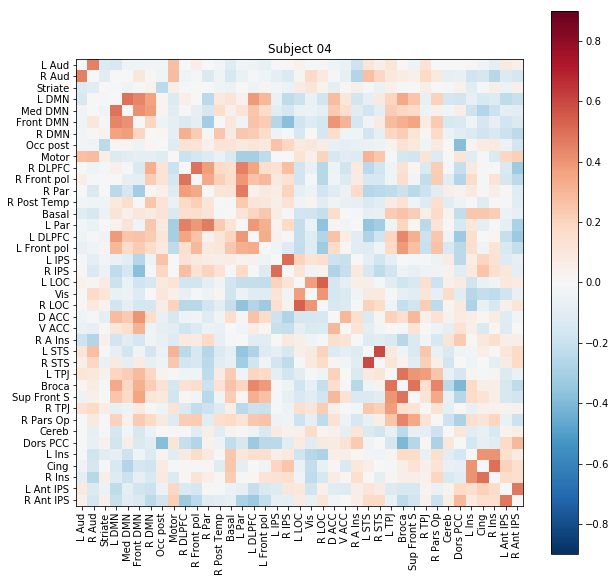

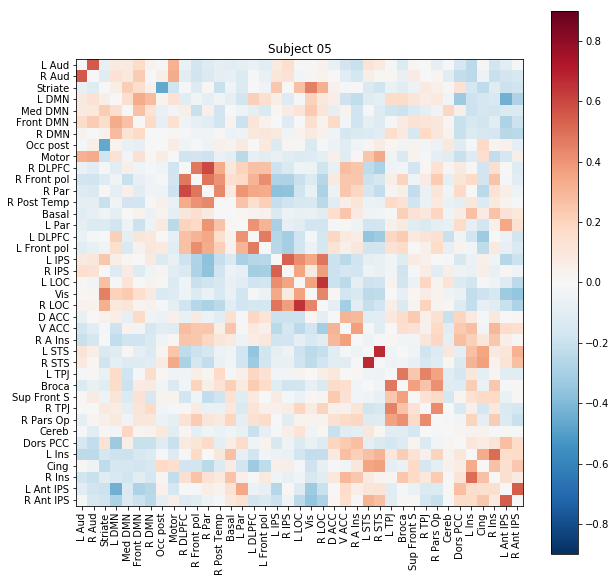

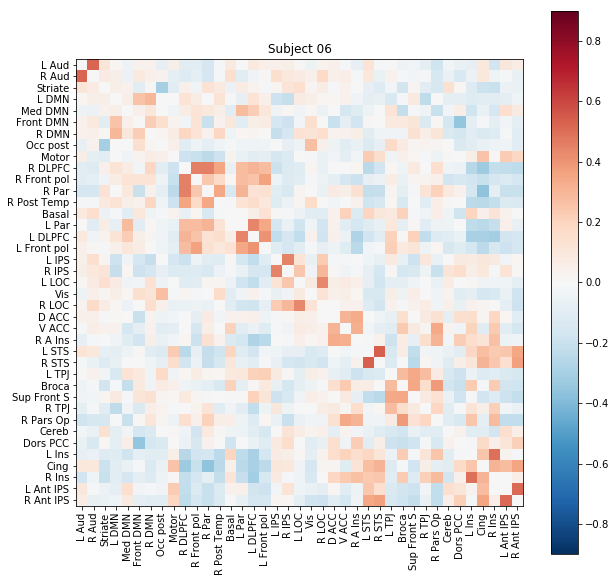

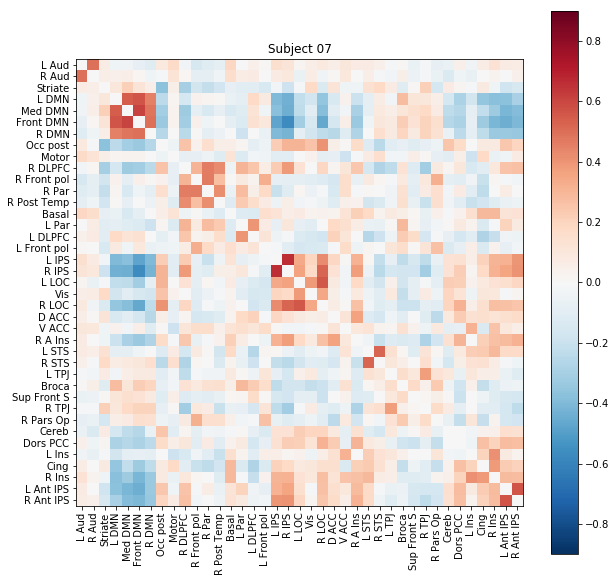

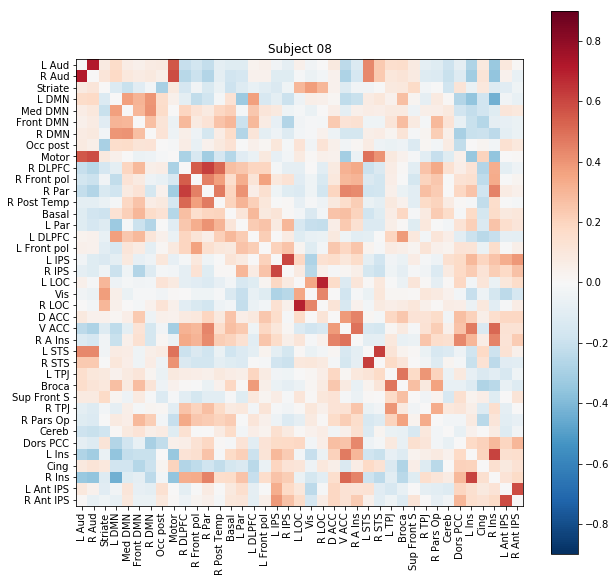

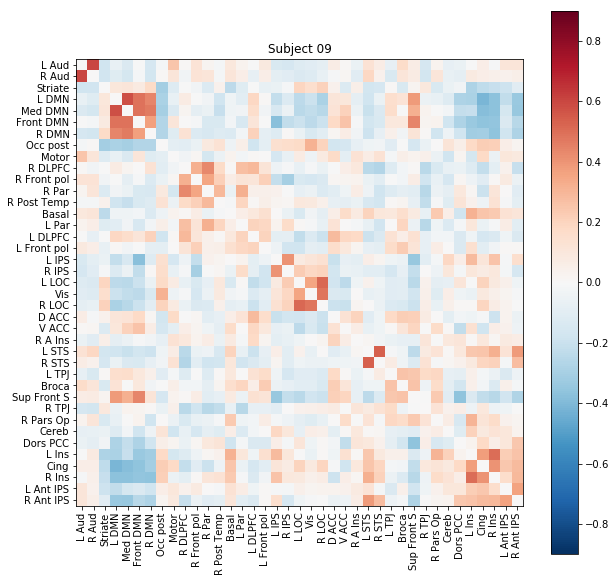

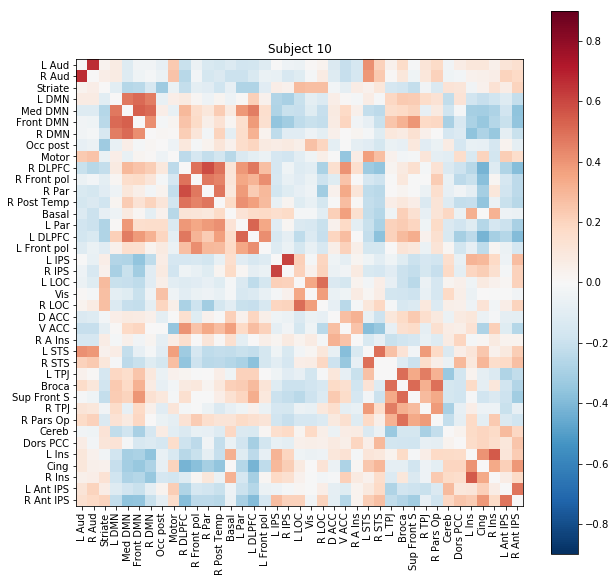

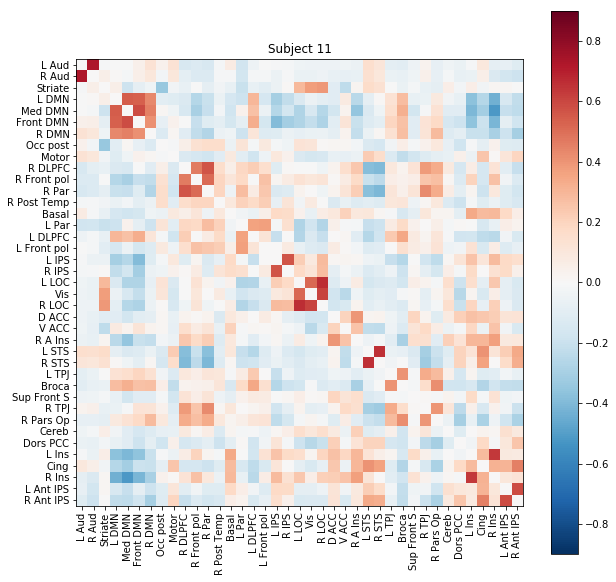

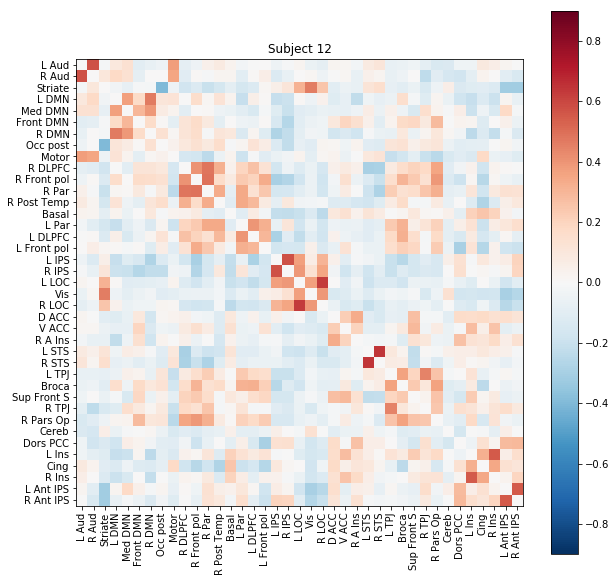

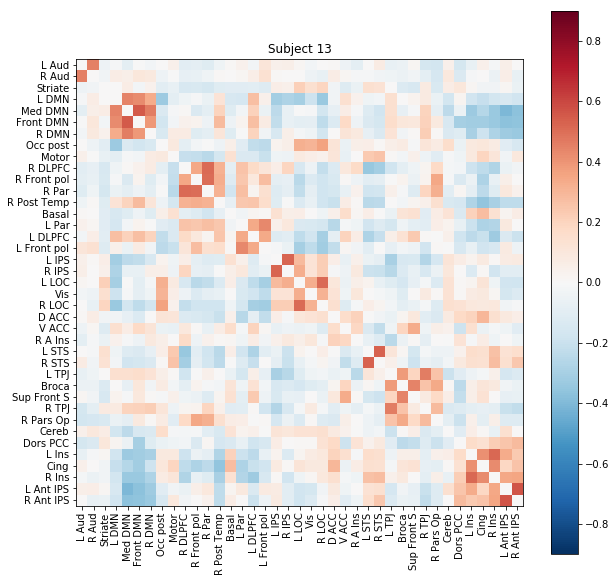

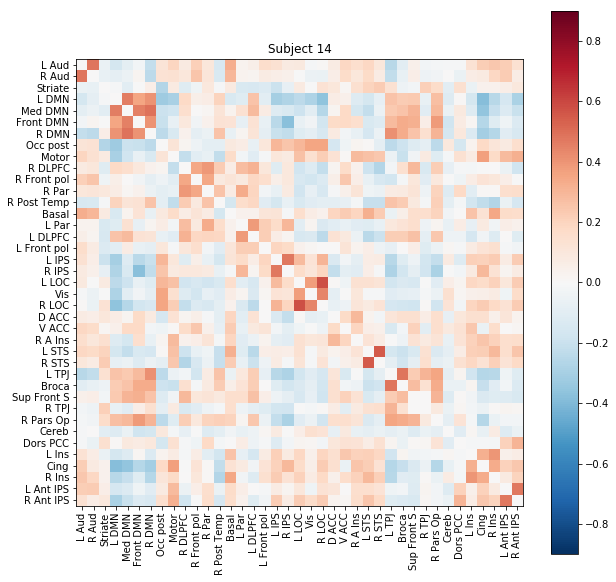

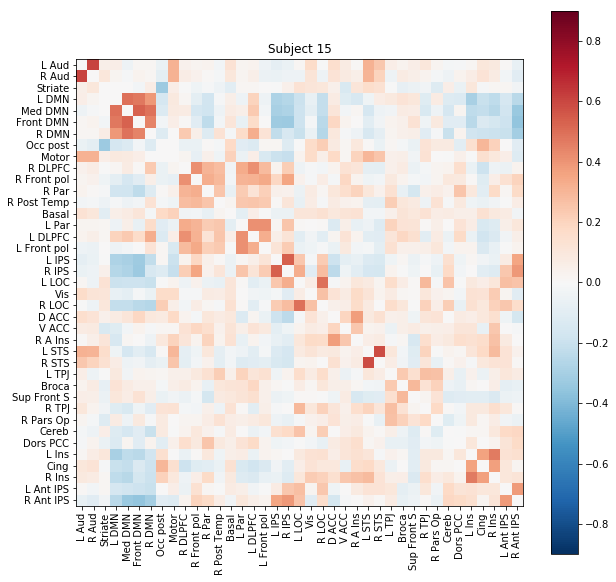

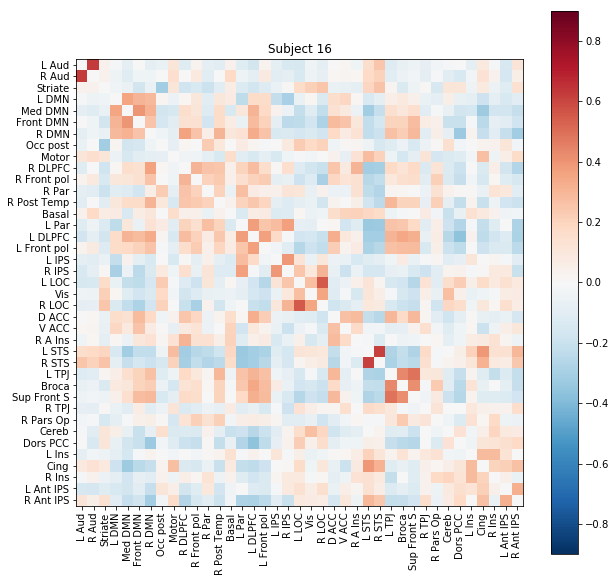

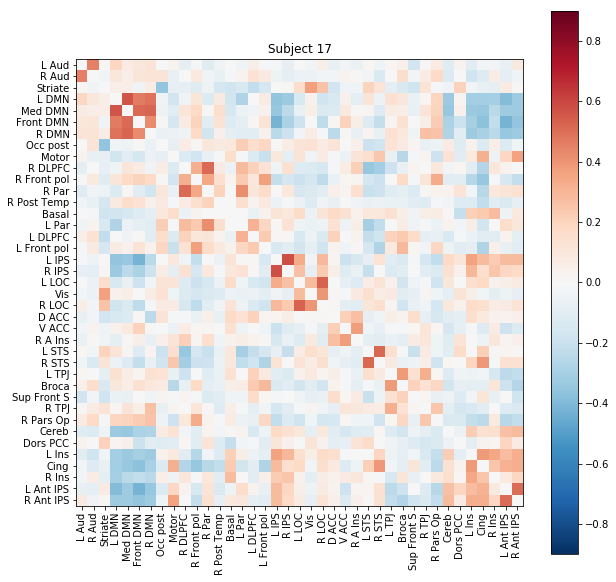

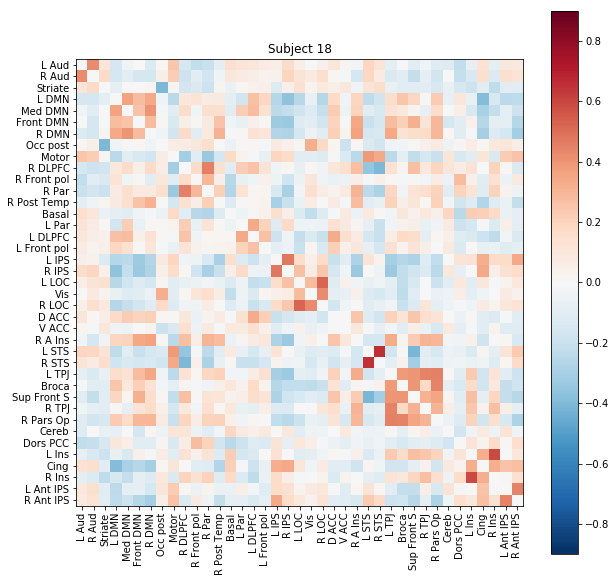

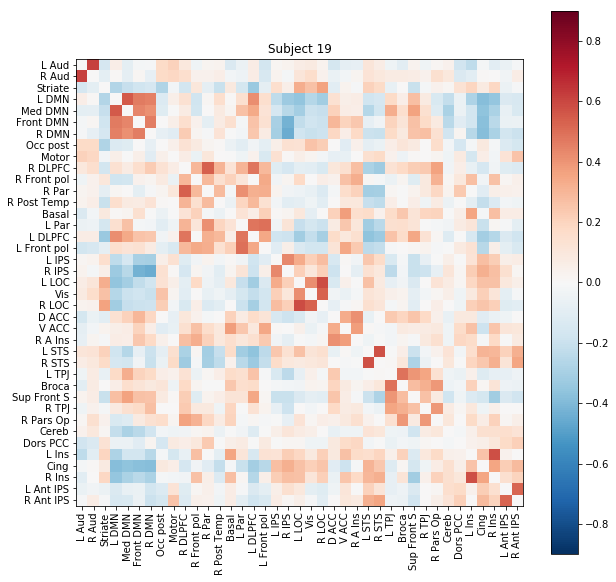

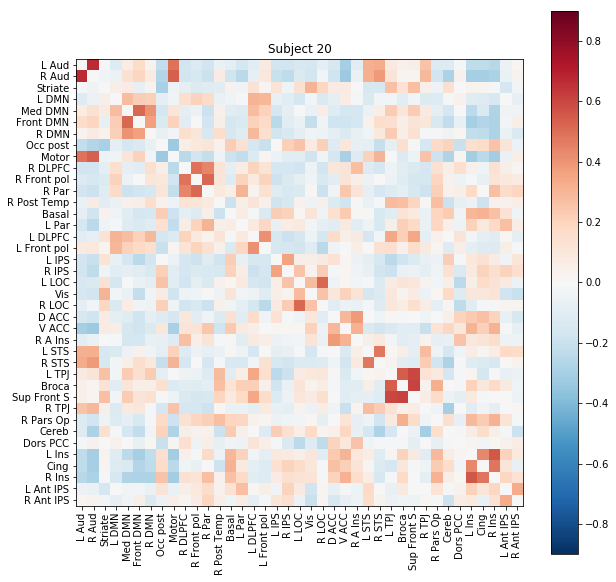

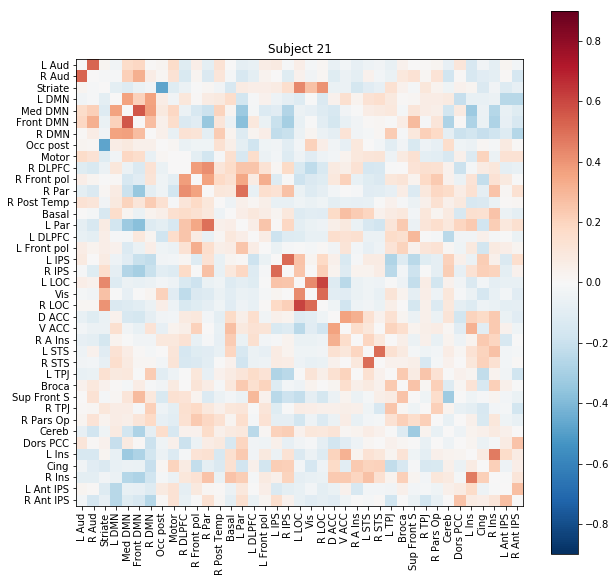

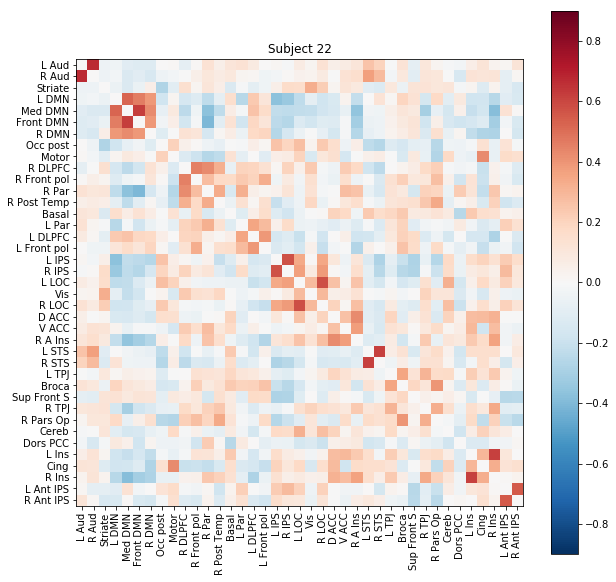

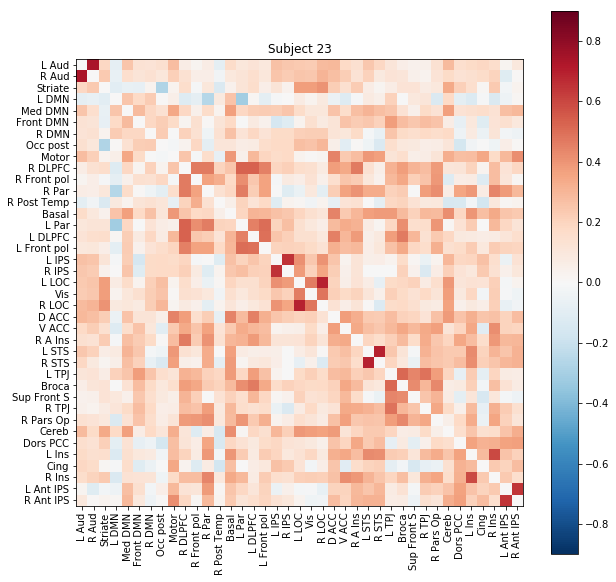

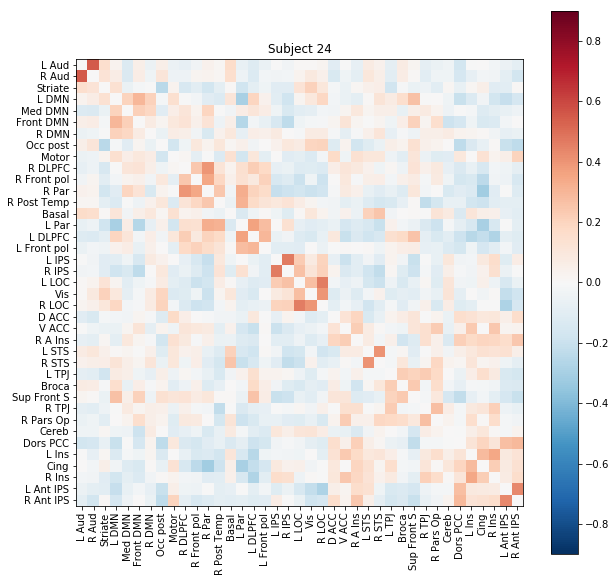

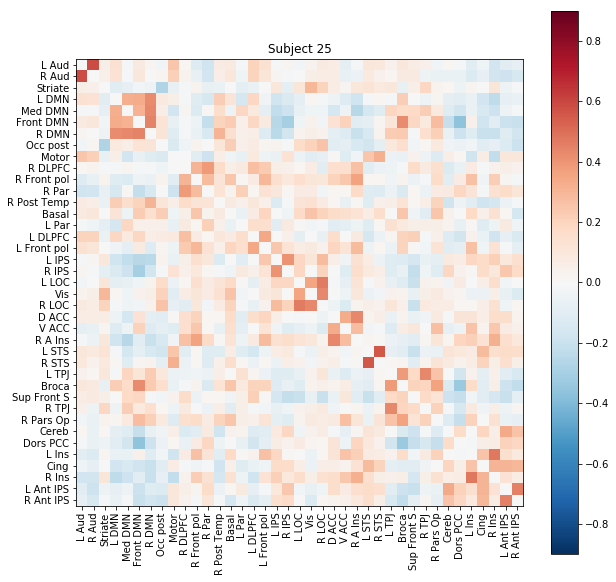

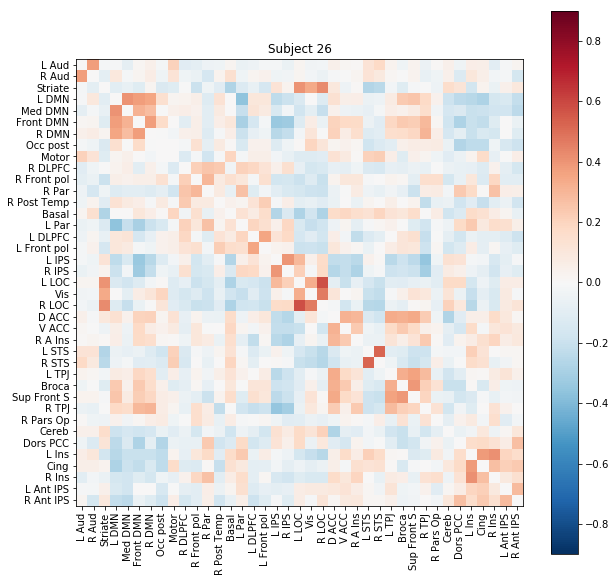

In [20]:
# Make a masker
masker = NiftiMapsMasker(maps_img=atlas_im, standardize=True, memory='nilearn_cache', memory_level=5)

# Make a list to fill up with correlation matrices
correlation_matrices = []


# Loop over 26 subjects
for subj_idx in ['%02d' % i for i in range(1, 27)]:
    
    print('Working on subject {}'.format(subj_idx))
    timeseries = []
    
    # loop over the 2 runs
    for run in ['01', '02']:
        
        # Make the path belonging to this subject and run
        path = os.path.join(os.environ['HOME'], 'data/openfmri/ds102/derivatives/fmriprep/sub-{subj_idx}/func/sub-{subj_idx}_task-flankertask'.format(**locals()))

        data = path + '_run-{}_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'.format(run)

        
        # Get the filenames that contain confounds
        confounds = path + '_run-{}_bold_confounds.tsv'.format(run)
        
        # Read the confounds in, replace the nans with nearest values
        confounds = pandas.read_csv(confounds, sep='\t', na_values='n/a').fillna(method='bfill')


        # Extract timeseries for every mask in the atlas
        ts = masker.fit_transform(data, confounds=confounds.values)
        timeseries.append(ts)
    
    
    # Create a correlation matrix for the two 
    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = np.mean(correlation_measure.fit_transform(timeseries), 0)
    plot_correlation_matrix(correlation_matrix)
    plt.title('Subject {}'.format(subj_idx))
    
    correlation_matrices.append(correlation_matrix)

### Mean correlation matrix

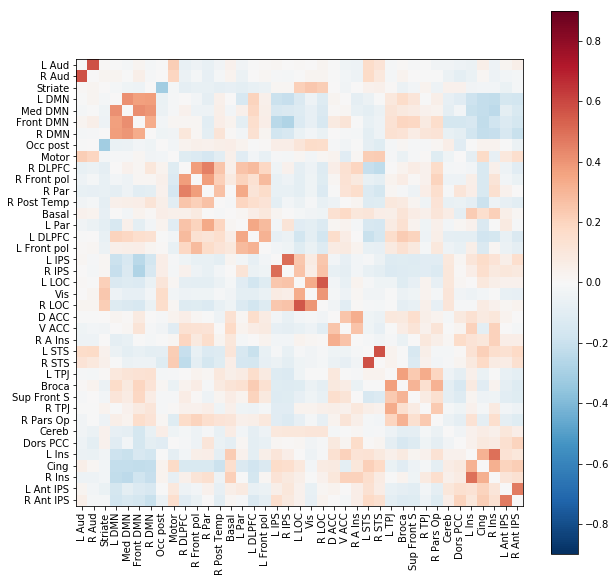

In [21]:
plot_correlation_matrix(np.mean(correlation_matrices, 0))

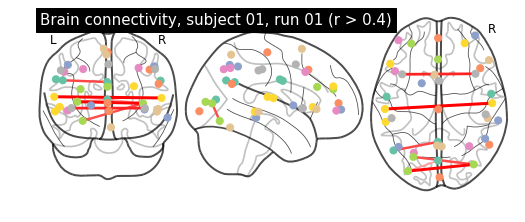

In [22]:
correlation_matrix = np.ma.masked_array(np.mean(correlation_matrices, 0), np.abs(correlation_matrix) < 0.4)
plotting.plot_connectome(correlation_matrix, coords_connectome, title='Brain connectivity, subject 01, run 01 (r > 0.4)')

## Model-based analysis

Now we will take the connectomes, and correlate all the connection strengths with DDM parameters

First we need the drift rates we fitted in 1) Behavior

In [23]:
import pandas
drift_rates = pandas.read_csv('drift_rates.csv')
drift_rates.head()

,subj_idx,congruent,incongruent
0,1,3.985537,3.223216
1,2,4.394947,3.340274
2,3,4.343104,3.422337
3,4,4.369257,3.380922
4,5,4.703891,3.401675


Let's look into individual variability in drift rate (drift reduction from congruent to incongruent)

In [24]:
drift_differences = drift_rates['congruent'] - drift_rates['incongruent']

This little function can correlate individual variables $y$  with a list of connectomes in X

In [25]:
import scipy as sp
from scipy import stats

In [26]:
def correlation_across_connectivity_matrics(y, X):
    n = X.shape[1]

    X = X.reshape((X.shape[0], -1))
    Xm = X.mean(0)
    ym = y.mean()

    r_num = ((X-Xm)*y[:, np.newaxis]).sum(0)
    r_den = np.sqrt(np.sum((X-Xm)**2,axis=0)*np.sum((y-ym)**2))
    
    r = r_num/r_den
    r = r.reshape((n, n))

    dof = X.shape[0] - 2

    t = (r * np.sqrt(dof)) / np.sqrt(1- r**2)

    p = 2 * sp.stats.t(dof).sf(t)
    
    return r, p

In [27]:
drift_differences = np.array(drift_differences)
correlation_matrices = np.array(correlation_matrices)

## Correlation between connection strength and drift reduction (unthresholded)

In [28]:
r, p = correlation_across_connectivity_matrics(drift_differences, correlation_matrices)

/Users/gilles/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in divide
  # This is added back by InteractiveShellApp.init_path()
/Users/gilles/anaconda3/envs/py27/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/gilles/anaconda3/envs/py27/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/gilles/anaconda3/envs/py27/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


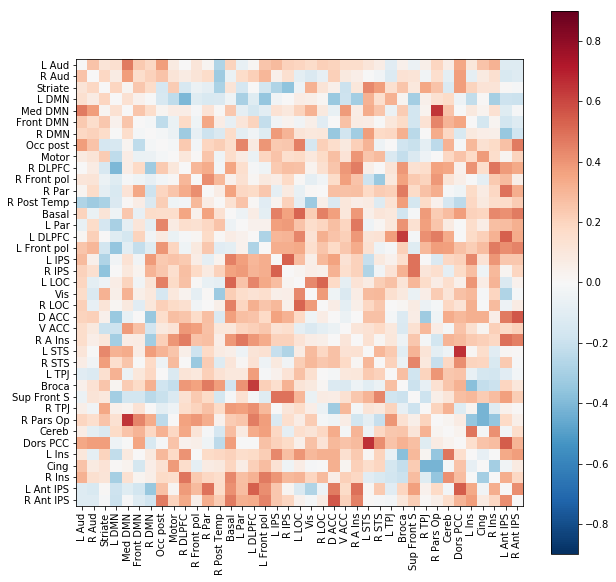

In [29]:
plot_correlation_matrix(r)

### With p < 0.005

/Users/gilles/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


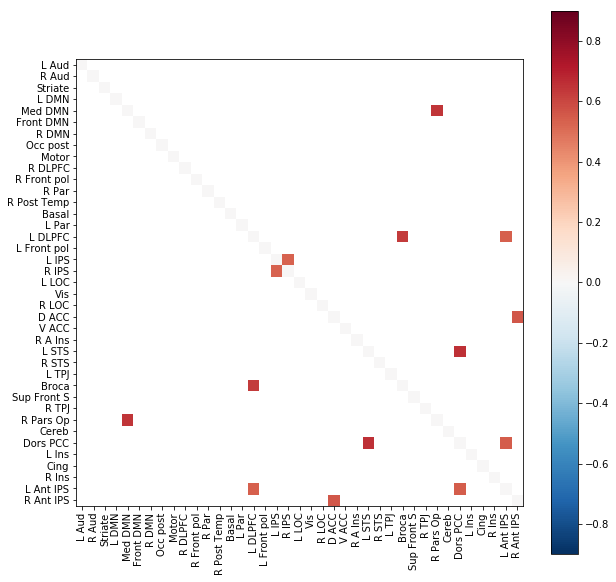

In [30]:
plot_correlation_matrix(np.ma.masked_array(r, p > 0.005))

In [31]:
import nilearn
from nilearn import plotting

In [32]:
np.nanmax(r)

0.65559452965308784

In [33]:
np.nanmin(p.ravel())

0.00027730365676581248

/Users/gilles/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


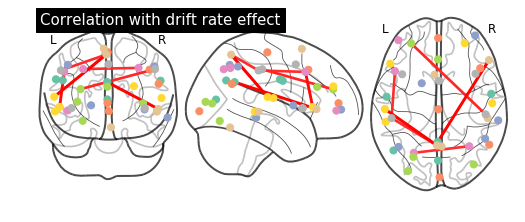

In [34]:
plotting.plot_connectome(np.ma.masked_array(r, p > 0.005), coords_connectome, title='Correlation with drift rate effect', )

Subjects that show a large effect of stimulus conflict show higher intra-DMN connectivity, as well as connectivity between association areas and visual areas!